<a href="https://colab.research.google.com/github/GeorgeLiang3/PINN_Bayesian/blob/main/BananaDistribution_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependency

In [1]:
!pip install ipython-autotime
%load_ext autotime
!pip install nptyping==1.0.1
!pip install tensorflow-probability==0.11.1

time: 5.75 s (started: 2021-05-06 16:33:38 +00:00)


In [2]:
import tensorflow as tf
import os
import numpy as np
import sys
import timeit
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
import seaborn as sns

from scipy import stats, optimize
import numpy.matlib
%matplotlib inline


time: 2.29 s (started: 2021-05-06 16:33:44 +00:00)


In [3]:
import copy
class SVN:
    def __init__(self, model,nParticles=100,nIterations=100, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = nParticles
        self.nIterations = nIterations
        self.stepsize = 1
        # self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]

        self.particles_list = []
        self.post_list = []
        self.mgJ_list = []
        self.HJ_list = []

        self.particles_list.append(copy.deepcopy(self.particles))

    def apply(self,debug = False):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        for iter_ in range(self.nIterations):
            # F = self.model.getForwardModel(self.particles)
            # J = self.model.getJacobianForwardModel(self.particles)
            gmlpt  = self.model.getADGradientMinusLogPosterior(self.particles)
            Hmlpt  = self.model.getADHessianMinusLogPosterior(self.particles)
            M = np.mean(Hmlpt, 2)
            thetas = constant32(self.particles)
            self.post_list.append(copy.deepcopy(self.model.getADMinusLogPosterior(thetas)))
            self.mgJ_list.append(copy.deepcopy(gmlpt))
            self.HJ_list.append(copy.deepcopy(Hmlpt))
            

            for i_ in range(self.nParticles):
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles
                Msd   = np.matmul(M, sign_diff)
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                gkern = Msd * kern
                
                mgJ = np.mean(- gmlpt * kern + gkern , 1)
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles

                Q[:,i_] = np.linalg.solve(HJ, mgJ)
                if debug == True:
                  print('HJ:',HJ)
                maxshift[i_] = np.linalg.norm(Q[:,i_], np.inf)

            if debug == True:
              print('Q:',Q)
              print('increment:',self.stepsize * Q)  
            self.particles += self.stepsize * Q

            self.particles_list.append(copy.deepcopy(self.particles))

            maxmaxshift = np.max(maxshift)
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        # self.particles = np.random.normal( scale = 1, size = (self.DoF, self.nParticles) )
        self.particles = np.random.uniform( low=-2, high=2, size = (self.DoF, self.nParticles) )


time: 82.1 ms (started: 2021-05-06 16:33:47 +00:00)


In [4]:
def constant32(x):
    return tf.convert_to_tensor(x,dtype=tf.float32)
class BANANA:

    def __init__(self):

        # initiate the model

        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A = np.ones( (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()

    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = thetas[0]+thetas[1]**2
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + noise

    def getADMinusLogPrior(self, thetas):
        # thetas = tf.reshape(thetas,[-1,self.DoF])
        thetas = tf.transpose(thetas)

        mvn = tfd.MultivariateNormalDiag(
            loc=tf.tile(tf.expand_dims(constant32(self.mu0.squeeze()),0),[thetas.shape[0],1]),
            scale_diag = tf.tile(tf.expand_dims(constant32(self.std0.squeeze()),0),[thetas.shape[0],1]))
        return -mvn.log_prob(thetas)

    def getADMinusLogLikelihood(self, thetas):

        # thetas = tf.reshape(thetas,[-1,self.DoF])
        thetas = tf.transpose(thetas)

        y = tfd.Normal(loc=thetas[:,0]+(thetas[:,1])**2, scale=constant32(self.stdn))
        return -tf.squeeze(y.log_prob(constant32(self.data)))
    
    
    @tf.function
    def getADMinusLogPosterior(self, thetas):
        """Calculate the joint posterior of a given point

        Arguments:
            theta {[tensor:float32]} 

        Returns:
            [tensor] -- value of the posterior
        """
        minusLogPrior = self.getADMinusLogPrior(thetas)
        minusLogLikelihood = self.getADMinusLogLikelihood(thetas)

        return minusLogPrior+minusLogLikelihood


    def getADGradientMinusLogPosterior(self, thetas):

        thetas = constant32(thetas)
        with tf.GradientTape() as tt:
            tt.watch(thetas)
            loss = self.getADMinusLogPosterior(thetas)
        grad = tt.gradient(loss, thetas, unconnected_gradients='zero')

        return grad

    def getADHessianMinusLogPosterior(self, thetas): 
        thetas = constant32(thetas)
        Hess = tf.TensorArray(tf.float32, size=2)
        j = 0
        for i in range(2):
            with tf.GradientTape() as t:
                t.watch(thetas)
                with tf.GradientTape() as tt:
                    tt.watch(thetas)
                    loss = self.getADMinusLogPosterior(thetas)
                jac = tt.gradient(loss, thetas, unconnected_gradients='zero')[i]
            hess = t.gradient(jac, thetas, unconnected_gradients='none')
            Hess = Hess.write(j, hess)
            j = j + 1
        hessian = tf.squeeze(Hess.stack())
        return hessian

time: 99.1 ms (started: 2021-05-06 16:33:47 +00:00)


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


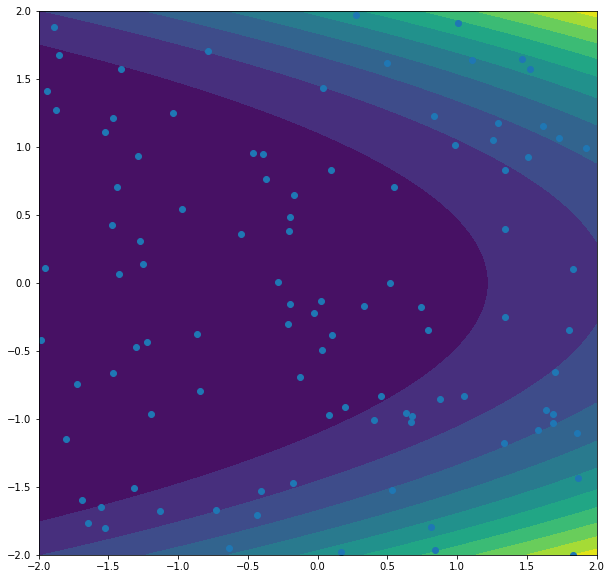

time: 1.25 s (started: 2021-05-06 16:33:47 +00:00)


In [5]:
Banana = BANANA()
svn = SVN(Banana)

ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 2, ngrid)
X, Y = np.meshgrid(x,y)
Z = tf.reshape(Banana.getADMinusLogPosterior( tf.convert_to_tensor(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ,dtype=tf.float32) ) \
    ,(ngrid, ngrid))

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [6]:
def constant32(x):
    return tf.convert_to_tensor(x,dtype=tf.float32)
class TFGAUSSIAN:

    def __init__(self):#, mu=[0.2, 0.3], cov=[[1,  0.], [0.,  1]]):

        # initiate the model


        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()

    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.sum(self.A * thetas, 0)
        return tmp if nSamples > 1 else tmp.squeeze()

    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.matlib.repmat(self.A, 1, nSamples)
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + noise
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)

    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()

    def getADMinusLogPrior(self, thetas):
        # thetas = tf.reshape(thetas,[-1,self.DoF])
        thetas = tf.transpose(thetas)

        mvn = tfd.MultivariateNormalDiag(
            loc=tf.tile(tf.expand_dims(constant32(self.mu0.squeeze()),0),[thetas.shape[0],1]),
            scale_diag = tf.tile(tf.expand_dims(constant32(self.std0.squeeze()),0),[thetas.shape[0],1]))
        return -mvn.log_prob(thetas)

    def getADMinusLogLikelihood(self, thetas):

        # thetas = tf.reshape(thetas,[-1,self.DoF])
        thetas = tf.transpose(thetas)

        y = tfd.Normal(loc=tf.matmul(thetas,constant32(self.A)), scale=constant32(self.stdn))
        return -tf.squeeze(y.log_prob(constant32(self.data)))
    
    
    @tf.function
    def getADMinusLogPosterior(self, thetas):
        """Calculate the joint posterior of a given point

        Arguments:
            theta {[tensor:float32]} 

        Returns:
            [tensor] -- value of the posterior
        """
        minusLogPrior = self.getADMinusLogPrior(thetas)
        minusLogLikelihood = self.getADMinusLogLikelihood(thetas)

        return minusLogPrior+minusLogLikelihood


    def getADGradientMinusLogPosterior(self, thetas):

        thetas = tf.convert_to_tensor(thetas)
        with tf.GradientTape() as tt:
            tt.watch(thetas)
            loss = self.getADMinusLogPosterior(thetas)
        grad = tt.gradient(loss, thetas, unconnected_gradients='zero')

        return grad

    def getADHessianMinusLogPosterior(self, thetas): 
        thetas = tf.convert_to_tensor(thetas,dtype = tf.float32)
        Hess = tf.TensorArray(tf.float32, size=2)
        j = 0
        for i in range(2):
            with tf.GradientTape() as t:
                t.watch(thetas)
                with tf.GradientTape() as tt:
                    tt.watch(thetas)
                    loss = self.getADMinusLogPosterior(thetas)
                jac = tt.gradient(loss, thetas, unconnected_gradients='zero')[i]
            hess = t.gradient(jac, thetas, unconnected_gradients='none')
            Hess = Hess.write(j, hess)
            j = j + 1
        hessian = tf.squeeze(Hess.stack())
        return hessian

time: 266 ms (started: 2021-05-06 16:33:48 +00:00)


In [7]:
tfgaussian = TFGAUSSIAN()

time: 2.33 ms (started: 2021-05-06 16:33:48 +00:00)


In [8]:
class GAUSSIAN():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.sum(self.A * thetas, 0)
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.matlib.repmat(self.A, 1, nSamples)
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + noise
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

time: 101 ms (started: 2021-05-06 16:33:48 +00:00)


In [9]:
model = TFGAUSSIAN()
svn = SVN(model)
# model.getGNHessianMinusLogPosterior(svn.particles)

time: 1.87 ms (started: 2021-05-06 16:33:48 +00:00)


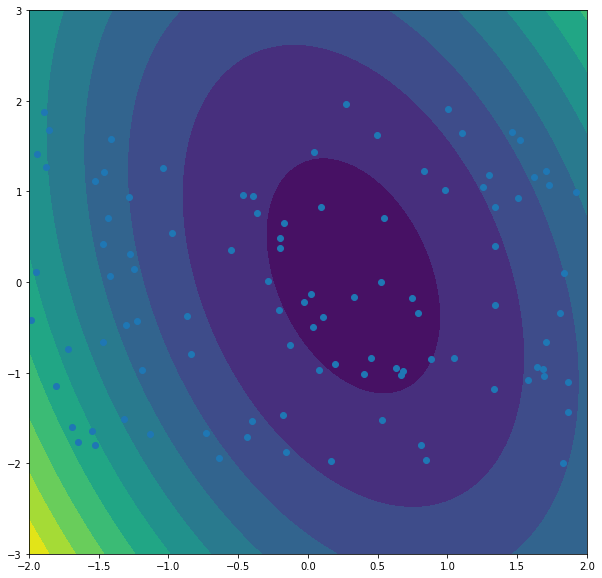

time: 870 ms (started: 2021-05-06 16:33:48 +00:00)


In [10]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = tf.reshape(tfgaussian.getADMinusLogPosterior( tf.convert_to_tensor(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ,dtype=tf.float32) ) \
    ,(ngrid, ngrid))

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [11]:
x_array,y_array = svn.particles[0],svn.particles[1]

time: 1.59 ms (started: 2021-05-06 16:33:49 +00:00)


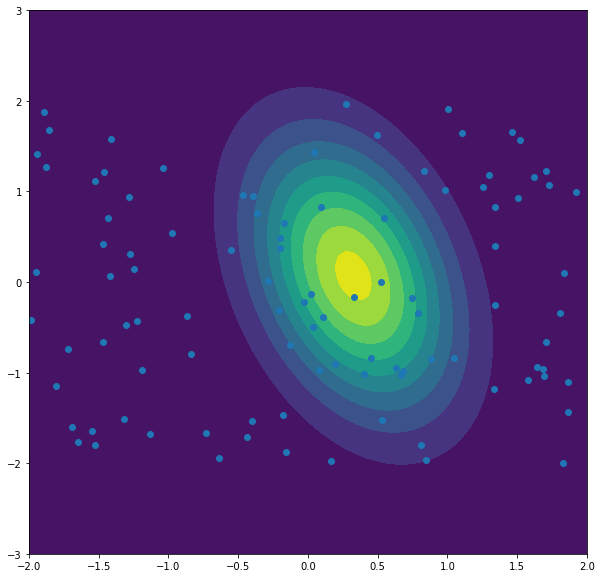

time: 424 ms (started: 2021-05-06 16:33:49 +00:00)


In [12]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

## Prepare the training data

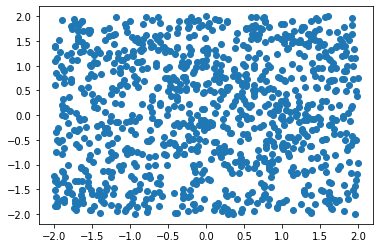

time: 2.77 s (started: 2021-05-06 16:33:50 +00:00)


In [13]:
model = BANANA()
svn = SVN(model,nParticles=1000,nIterations=1)
svn.apply()
init = np.copy(svn.particles_list[0])
plt.scatter(init[0],init[1])

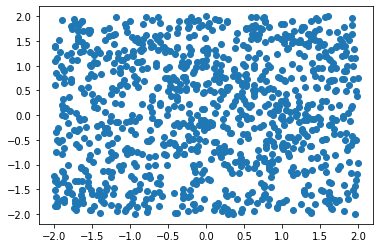

time: 238 ms (started: 2021-05-06 16:33:53 +00:00)


In [14]:
x_array,y_array = init[0],init[1]
plt.scatter(x_array, y_array)

In [15]:
post_list = np.squeeze(np.array(svn.post_list))

time: 1.91 ms (started: 2021-05-06 16:33:53 +00:00)


In [16]:
mgJ_list = np.squeeze(np.array(svn.mgJ_list))

time: 2.33 ms (started: 2021-05-06 16:33:53 +00:00)


In [17]:
HJ_list = np.squeeze(np.array(svn.HJ_list))

time: 1.11 ms (started: 2021-05-06 16:33:53 +00:00)


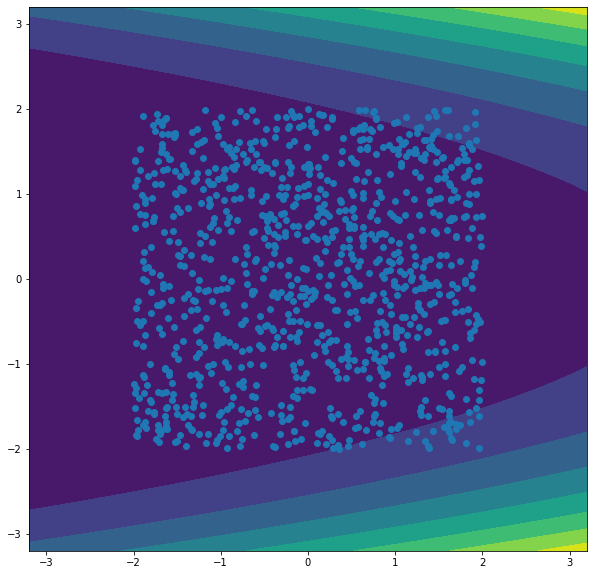

time: 438 ms (started: 2021-05-06 16:33:53 +00:00)


In [18]:
ngrid = 100
x = np.linspace(-3.2, 3.2, ngrid)
y = np.linspace(-3.2, 3.2, ngrid)
X, Y = np.meshgrid(x,y)
Z = tf.reshape(model.getADMinusLogPosterior( tf.convert_to_tensor(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ,dtype=tf.float32) ) \
    ,(ngrid, ngrid))

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(x_array, y_array)

In [19]:
def tensor(x):
  return tf.convert_to_tensor(x, dtype = tf.float32)

x1 = tensor(x_array)
x2 = tensor(y_array)
u = tensor(post_list)
u_x1 = tensor(mgJ_list[0])
u_x2 = tensor(mgJ_list[1])
u_x1x1 = tensor(HJ_list[0][0])
u_x1x2 = tensor(HJ_list[0][1])
u_x2x2 = tensor(HJ_list[1][1])
u_x2x1 = tensor(HJ_list[1][0])

time: 7.68 ms (started: 2021-05-06 16:33:53 +00:00)


In [20]:
HJ_list[:,:,:100]

array([[[ 1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+01,  1.21111107e+01,
          1.21111107e+01,  1.21111107e+0

time: 11.8 ms (started: 2021-05-06 16:33:53 +00:00)


# **PINN**

## Utils

In [21]:
#pulled from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time


def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times
  
  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None
    
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break
    
    if tf.abs(f,f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)



time: 334 ms (started: 2021-05-06 16:33:53 +00:00)


## Neural Net

I just re-built a version of this and had to make some changes to the network structure to achieve convergence. Your layer input regularization (for which you use a lambda layer in Keras) isn't applied to every layer, which is likely causing an issue with the size of the gradients. Since the tanh function is used (which is really only good in a small range), a large value in the output of the dense layer is likely causing the gradients to vanish as the training progresses. I had to create a custom layer in Keras to implement the regularization Raissi used, which fixed the issue for me. However, I did this for continuous inference of Allan-Cahn, not schrodingers. So you may achieve better convergence in this version if you change your activations from tanh to LeakyReLU. Or build a custom class layer instead of using the built-in Dense layer from Keras (which is what I did) to fix this issue.
[-- levimcclenny](https://github.com/pierremtb/PINNs-TF2.0/issues/1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations

#define size of the network
layer_sizes = [2, 128, 128, 128, 128, 1]

sizes_w = []
sizes_b = []

for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))

#L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0
def set_weights(model, w, sizes_w, sizes_b):
    for i, layer in enumerate(model.layers[0:]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)

def get_weights(model):
    w = []
    for layer in model.layers[0:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)

    w = tf.convert_to_tensor(w)
    return w


#define the neural network model
def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model

#define the neural network model
def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model

#initialize the NN
u_model = neural_net(layer_sizes)

#view the NN
u_model.summary()

def loss(x1,x2,u,u_x1,u_x2,u_x1x1,u_x1x2,u_x2x2,u_x2x1):
    u_pred = u_model(tf.concat([x1, x2],1))
    u_x1_pred,u_x2_pred = grad_model(x1, x2)
    u_x1x1_pred,u_x1x2_pred,u_x2x2_pred,u_x2x1_pred=Hess_model(x1,x2)

    mse_u = tf.reduce_mean(tf.square(u_pred - u))
    mse_g = tf.reduce_mean(tf.square(u_x1_pred - u_x1))+ \
            tf.reduce_mean(tf.square(u_x2_pred - u_x2))

    mse_h = tf.reduce_mean(tf.square(u_x1x1_pred - u_x1x1)) + \
            tf.reduce_mean(tf.square(u_x1x2_pred - u_x1x2)) + \
            tf.reduce_mean(tf.square(u_x2x2_pred - u_x2x2)) + \
            tf.reduce_mean(tf.square(u_x2x1_pred - u_x2x1))
    
    # force the hessian be symmetric
    diff_off_diag = u_x1x2_pred - u_x2x1_pred
    
    ku = tf.constant(1.,dtype = tf.float32)
    kg = tf.constant(0.2,dtype = tf.float32)
    kh = tf.constant(0.1,dtype = tf.float32)

    return ku*mse_u + kg* mse_g + kh*mse_h, mse_u, mse_g, mse_h # + diff_off_diag
    # return ku*mse_u, mse_u, mse_g, mse_h # + diff_off_diag

@tf.function
def grad_model(x1,x2):
    u = u_model(tf.concat([x1,x2], 1))
    u_x1, u_x2 = tf.gradients(u,[x1,x2])
    # u_x2 = tf.gradients(u,x2)
    return u_x1,u_x2

@tf.function
def Hess_model(x1,x2):
    u = u_model(tf.concat([x1,x2], 1))
    u_x1, u_x2 = tf.gradients(u,[x1,x2])

    u_x1x1,u_x1x2 = tf.gradients(u_x1,[x1,x2])
    # u_x1x2 = tf.gradients(u_x1, x2)
    u_x2x2,u_x2x1 = tf.gradients(u_x2,[x2,x1])
    # u_x2x1 = tf.gradients(u_x2,x1)
    return u_x1x1,u_x1x2,u_x2x2,u_x2x1


@tf.function
def grad(u_model,x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_u, mse_g, mse_h = loss(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)
        grads = tape.gradient(loss_value, u_model.trainable_variables)
        print(grads)

    return loss_value, grads, mse_u, mse_g, mse_h

def fit(x1,x2,u,u_x1,u_x2,u_x1x1,u_x1x2,u_x2x2,u_x2x1,tf_iter, newton_iter):
    # Built in support for mini-batch, set to N_f (i.e. full batch) by default
    batch_sz = N_f
    n_batches =  N_f // batch_sz
    start_time = time.time()
    tf_optimizer = tf.keras.optimizers.Adam(lr = 0.0005, beta_1=.90)

    print("starting Adam training")

    for epoch in range(tf_iter):
        for i in range(n_batches):

            x1_batch =  x1[i*batch_sz:(i*batch_sz + batch_sz),]
            x2_batch =  x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_batch = u[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1_batch = u_x1[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2_batch = u_x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1x1_batch = u_x1x1[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1x2_batch = u_x1x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2x2_batch = u_x2x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2x1_batch = u_x2x1[i*batch_sz:(i*batch_sz + batch_sz),]


            loss_value, grads, mse_u, mse_g, mse_h= grad(u_model,x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))



        if epoch % 10 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))

            loss_test, grads_test, mse_u_test, mse_g_test, mse_h_test= grad(u_model,x1_test,x2_test,u_test,u_x1_test,u_x2_test,u_x1x1_test,u_x1x2_test,u_x2x2_test,u_x2x1_test)

            tf.print(f"mse_u: {mse_u}  mse_g: {mse_g} mse_h: {mse_h}  total loss: {loss_value} mse_u_test: {mse_u_test}")
            start_time = time.time()


    # #l-bfgs-b optimization
    # print("Starting L-BFGS training")

    # loss_and_flat_grad = get_loss_and_flat_grad(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)

    # lbfgs(loss_and_flat_grad,
    #   get_weights(u_model),
    #   Struct(), maxIter=newton_iter, learningRate=0.8)




#L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _, _ = loss(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 50,049
Trainable params: 50,049
Non-trainable params: 0
_________________________________________________________________
time: 512 ms (started: 2021-05-06 16:33:54 +00:00)


In [23]:
n_train = 25
n_test = 100
tf_iter =100000
newton_iter = 100

N_f = n_train

x1_train = tf.reshape(x1[:n_train],[n_train,1])
x2_train = tf.reshape(x2[:n_train],[n_train,1])
u_train = tf.reshape(u[:n_train],[n_train,1])
u_x1_train = tf.reshape(u_x1[:n_train],[n_train,1])
u_x2_train = tf.reshape(u_x2[:n_train],[n_train,1])
u_x1x1_train = tf.reshape(u_x1x1[:n_train],[n_train,1])
u_x1x2_train = tf.reshape(u_x1x2[:n_train],[n_train,1])
u_x2x2_train = tf.reshape(u_x2x2[:n_train],[n_train,1])
u_x2x1_train = tf.reshape(u_x2x1[:n_train],[n_train,1])

x1_test = tf.reshape(x1[-n_test:],[n_test,1])
x2_test = tf.reshape(x2[-n_test:],[n_test,1])
u_test = tf.reshape(u[-n_test:],[n_test,1])
u_x1_test = tf.reshape(u_x1[-n_test:],[n_test,1])
u_x2_test = tf.reshape(u_x2[-n_test:],[n_test,1])
u_x1x1_test = tf.reshape(u_x1x1[-n_test:],[n_test,1])
u_x1x2_test = tf.reshape(u_x1x2[-n_test:],[n_test,1])
u_x2x2_test = tf.reshape(u_x2x2[-n_test:],[n_test,1])
u_x2x1_test = tf.reshape(u_x2x1[-n_test:],[n_test,1])


time: 36.4 ms (started: 2021-05-06 16:33:54 +00:00)


In [24]:
fit(x1_train,x2_train,u_train,u_x1_train,u_x2_train,u_x1x1_train,u_x1x2_train,u_x2x2_train,u_x2x1_train,tf_iter, newton_iter)

Streaming output truncated to the last 5000 lines.
mse_u: 0.0015596583252772689  mse_g: 0.01518282014876604 mse_h: 0.4521143436431885  total loss: 0.049807656556367874 mse_u_test: 0.7155516743659973
It: 75010, Time: 0.11
mse_u: 0.010520372539758682  mse_g: 0.028315963223576546 mse_h: 0.3262503147125244  total loss: 0.04880859702825546 mse_u_test: 0.7189140915870667
It: 75020, Time: 0.11
mse_u: 0.0004307872732169926  mse_g: 0.01110861822962761 mse_h: 0.05305507406592369  total loss: 0.007958019152283669 mse_u_test: 0.7113988995552063
It: 75030, Time: 0.10
mse_u: 0.003608188359066844  mse_g: 0.02507999911904335 mse_h: 0.05219761282205582  total loss: 0.013843949884176254 mse_u_test: 0.7137674689292908
It: 75040, Time: 0.10
mse_u: 0.013605643063783646  mse_g: 0.05109642818570137 mse_h: 0.09218999743461609  total loss: 0.03304392844438553 mse_u_test: 0.7154440879821777
It: 75050, Time: 0.09
mse_u: 0.16612102091312408  mse_g: 0.3956547677516937 mse_h: 0.8008082509040833  total loss: 0.32533

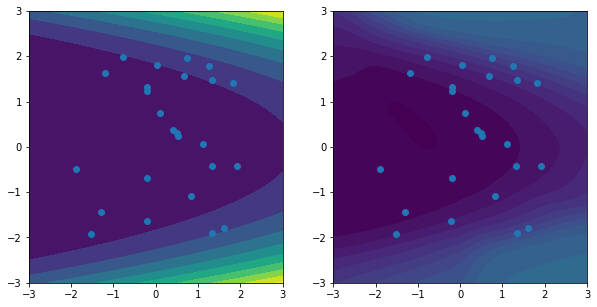

time: 407 ms (started: 2021-05-06 16:51:32 +00:00)


In [25]:
ngrid = 100
x = np.linspace(-3, 3, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z_pred = u_model(np.stack([X.flatten(),Y.flatten()], axis=1)).numpy().reshape(ngrid,ngrid)

Z_true =  tf.reshape(model.getADMinusLogPosterior( tf.convert_to_tensor(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ,dtype=tf.float32) ) \
    ,(ngrid, ngrid))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


global_max = np.max(Z_true)
global_min = np.min(Z_true)


axes[0].contourf(X, Y, Z_true, 10,vmin=global_min, vmax=global_max)
axes[0].scatter(x1_train, x2_train)
axes[1].contourf(X, Y, Z_pred, 10,vmin=global_min, vmax=global_max)
axes[1].scatter(x1_train, x2_train)


In [32]:
def loss_no_grad(x1,x2,u,u_x1,u_x2,u_x1x1,u_x1x2,u_x2x2,u_x2x1):
    u_pred = u_model_no_grad(tf.concat([x1, x2],1))
    u_x1_pred,u_x2_pred = grad_model_no_grad(x1, x2)
    u_x1x1_pred,u_x1x2_pred,u_x2x2_pred,u_x2x1_pred=Hess_model_no_grad(x1,x2)

    mse_u = tf.reduce_mean(tf.square(u_pred - u))
    mse_g = tf.reduce_mean(tf.square(u_x1_pred - u_x1))+ \
            tf.reduce_mean(tf.square(u_x2_pred - u_x2))

    mse_h = tf.reduce_mean(tf.square(u_x1x1_pred - u_x1x1)) + \
            tf.reduce_mean(tf.square(u_x1x2_pred - u_x1x2)) + \
            tf.reduce_mean(tf.square(u_x2x2_pred - u_x2x2)) + \
            tf.reduce_mean(tf.square(u_x2x1_pred - u_x2x1))
    
    # force the hessian be symmetric
    diff_off_diag = u_x1x2_pred - u_x2x1_pred
    
    ku = tf.constant(1.,dtype = tf.float32)
    kg = tf.constant(1.,dtype = tf.float32)
    kh = tf.constant(1.,dtype = tf.float32)

    # return ku*mse_u + kg* mse_g + kh*mse_h, mse_u, mse_g, mse_h # + diff_off_diag
    return ku*mse_u, mse_u, mse_g, mse_h # + diff_off_diag

@tf.function
def grad_model_no_grad(x1,x2):
    u = u_model_no_grad(tf.concat([x1,x2], 1))
    u_x1, u_x2 = tf.gradients(u,[x1,x2])
    # u_x2 = tf.gradients(u,x2)
    return u_x1,u_x2

@tf.function
def Hess_model_no_grad(x1,x2):
    u = u_model_no_grad(tf.concat([x1,x2], 1))
    u_x1, u_x2 = tf.gradients(u,[x1,x2])

    u_x1x1,u_x1x2 = tf.gradients(u_x1,[x1,x2])
    # u_x1x2 = tf.gradients(u_x1, x2)
    u_x2x2,u_x2x1 = tf.gradients(u_x2,[x2,x1])
    # u_x2x1 = tf.gradients(u_x2,x1)
    return u_x1x1,u_x1x2,u_x2x2,u_x2x1


@tf.function
def grad_no_grad(u_model_no_grad,x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_u, mse_g, mse_h = loss_no_grad(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)
        grads = tape.gradient(loss_value, u_model_no_grad.trainable_variables)
        print(grads)

    return loss_value, grads, mse_u, mse_g, mse_h

def fit_no_grad(x1,x2,u,u_x1,u_x2,u_x1x1,u_x1x2,u_x2x2,u_x2x1,tf_iter, newton_iter):
    # Built in support for mini-batch, set to N_f (i.e. full batch) by default
    batch_sz = N_f
    n_batches =  N_f // batch_sz
    start_time = time.time()
    tf_optimizer = tf.keras.optimizers.Adam(lr = 0.0005, beta_1=.90)

    print("starting Adam training")

    for epoch in range(tf_iter):
        for i in range(n_batches):

            x1_batch =  x1[i*batch_sz:(i*batch_sz + batch_sz),]
            x2_batch =  x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_batch = u[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1_batch = u_x1[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2_batch = u_x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1x1_batch = u_x1x1[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x1x2_batch = u_x1x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2x2_batch = u_x2x2[i*batch_sz:(i*batch_sz + batch_sz),]
            u_x2x1_batch = u_x2x1[i*batch_sz:(i*batch_sz + batch_sz),]


            loss_value, grads, mse_u, mse_g, mse_h= grad_no_grad(u_model_no_grad,x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)

            tf_optimizer.apply_gradients(zip(grads, u_model_no_grad.trainable_variables))



        if epoch % 10 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_u: {mse_u}  mse_g: {mse_g} mse_h: {mse_h}  total loss: {loss_value}")
            start_time = time.time()


    # #l-bfgs-b optimization
    # print("Starting L-BFGS training")

    # loss_and_flat_grad = get_loss_and_flat_grad_no_grad(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)

    # lbfgs(loss_and_flat_grad,
    #   get_weights(u_model_no_grad),
    #   Struct(), maxIter=newton_iter, learningRate=0.8)




#L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad_no_grad(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model_no_grad, w, sizes_w, sizes_b)
            loss_value, _, _, _ = loss(x1_batch,x2_batch,u_batch,u_x1_batch,u_x2_batch,u_x1x1_batch,u_x1x2_batch,u_x2x2_batch,u_x2x1_batch)
        grad = tape.gradient(loss_value, u_model_no_grad.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad

#initialize the NN
u_model_no_grad = neural_net(layer_sizes)

#view the NN
u_model_no_grad.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 50,049
Trainable params: 50,049
Non-trainable params: 0
_________________________________________________________________
time: 262 ms (started: 2021-05-06 17:01:01 +00:00)


In [33]:
tf_iter =100000
newton_iter = 100

time: 1.07 ms (started: 2021-05-06 17:01:03 +00:00)


In [34]:
fit_no_grad(x1_train,x2_train,u_train,u_x1_train,u_x2_train,u_x1x1_train,u_x1x2_train,u_x2x2_train,u_x2x1_train,tf_iter, newton_iter)

Streaming output truncated to the last 5000 lines.
mse_u: 6.346496320475126e-06  mse_g: 14720.015625 mse_h: 53062.5859375  total loss: 6.346496320475126e-06
It: 75010, Time: 0.07
mse_u: 4.506668574322248e-06  mse_g: 14720.712890625 mse_h: 52926.09375  total loss: 4.506668574322248e-06
It: 75020, Time: 0.08
mse_u: 1.0157489214179805e-06  mse_g: 14720.34375 mse_h: 52962.3828125  total loss: 1.0157489214179805e-06
It: 75030, Time: 0.08
mse_u: 1.1509052910696482e-06  mse_g: 14720.1572265625 mse_h: 52970.8671875  total loss: 1.1509052910696482e-06
It: 75040, Time: 0.08
mse_u: 8.322775784108671e-07  mse_g: 14720.310546875 mse_h: 52923.859375  total loss: 8.322775784108671e-07
It: 75050, Time: 0.09
mse_u: 5.807510774502589e-07  mse_g: 14720.1416015625 mse_h: 52937.2890625  total loss: 5.807510774502589e-07
It: 75060, Time: 0.08
mse_u: 4.31603609740705e-07  mse_g: 14720.1904296875 mse_h: 52911.6171875  total loss: 4.31603609740705e-07
It: 75070, Time: 0.08
mse_u: 3.32675256231596e-07  mse_g: 1

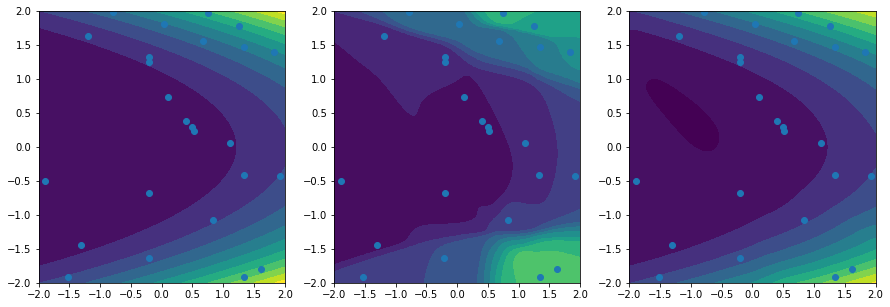

time: 695 ms (started: 2021-05-06 17:14:35 +00:00)


In [35]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 2, ngrid)
X, Y = np.meshgrid(x,y)
Z_pred = u_model(np.stack([X.flatten(),Y.flatten()], axis=1)).numpy().reshape(ngrid,ngrid)

Z_pred_no_grad = u_model_no_grad(np.stack([X.flatten(),Y.flatten()], axis=1)).numpy().reshape(ngrid,ngrid)

Z_true =  tf.reshape(model.getADMinusLogPosterior( tf.convert_to_tensor(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ,dtype=tf.float32) ) \
    ,(ngrid, ngrid))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


global_max = np.max(Z_true)
global_min = np.min(Z_true)


axes[0].contourf(X, Y, Z_true, 10,vmin=global_min, vmax=global_max)
axes[0].scatter(x1_train, x2_train)

axes[1].contourf(X, Y, Z_pred_no_grad, 10,vmin=global_min, vmax=global_max)
axes[1].scatter(x1_train, x2_train)

axes[2].contourf(X, Y, Z_pred, 10,vmin=global_min, vmax=global_max)
axes[2].scatter(x1_train, x2_train)


In [30]:

# class NeuralNetwork(object):
#     def __init__(self, hp, logger, ub, lb):
#         """
#           ub,lb: upper bound and lower bound
#         """

#         layers = hp["layers"]

#         # Setting up the optimizers with the hyper-parameters
#         self.nt_config = Struct()
#         self.nt_config.learningRate = hp["nt_lr"]
#         self.nt_config.maxIter = hp["nt_epochs"]
#         self.nt_config.nCorrection = hp["nt_ncorr"]
#         self.nt_config.tolFun = 1.0 * np.finfo(float).eps
#         self.tf_epochs = hp["tf_epochs"]
#         self.tf_optimizer = tf.keras.optimizers.Adam(
#             learning_rate=hp["tf_lr"],
#             beta_1=hp["tf_b1"],
#             epsilon=hp["tf_eps"])

#         self.dtype = "float64"
#         # Descriptive Keras model
#         tf.keras.backend.set_floatx(self.dtype)
#         self.model = tf.keras.Sequential()
#         self.model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
#         self.model.add(tf.keras.layers.Lambda(
#             lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
#         for width in layers[1:-1]:
#             self.model.add(tf.keras.layers.Dense(
#                 width, activation=tf.nn.tanh,
#                 kernel_initializer="glorot_normal"))
#         self.model.add(tf.keras.layers.Dense(
#                 layers[-1], activation=None,
#                 kernel_initializer="glorot_normal"))

#         # Computing the sizes of weights/biases for future decomposition
#         self.sizes_w = []
#         self.sizes_b = []
#         for i, width in enumerate(layers):
#             if i != 1:
#                 self.sizes_w.append(int(width * layers[1]))
#                 self.sizes_b.append(int(width if i != 0 else layers[1]))

#         self.logger = logger

#     # Defining custom loss
#     # @tf.function
#     def loss(self, u, u_pred):
#         return tf.reduce_mean(tf.square(u - u_pred))

#     # @tf.function
#     def grad(self, X, u):
#         with tf.GradientTape() as tape:
#             loss_value = self.loss(u, self.model(X))
#         grads = tape.gradient(loss_value, self.wrap_training_variables())
#         return loss_value, grads

#     def wrap_training_variables(self):
#         var = self.model.trainable_variables
#         return var

#     def get_params(self, numpy=False):
#         return []

#     def get_weights(self, convert_to_tensor=True):
#         w = []
#         for layer in self.model.layers[1:]:
#             weights_biases = layer.get_weights()
#             weights = weights_biases[0].flatten()
#             biases = weights_biases[1]
#             w.extend(weights)
#             w.extend(biases)
#         if convert_to_tensor:
#             w = self.tensor(w)
#         return w

#     def set_weights(self, w):
#         for i, layer in enumerate(self.model.layers[1:]):
#             start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
#             end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
#             weights = w[start_weights:end_weights]
#             w_div = int(self.sizes_w[i] / self.sizes_b[i])
#             weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
#             biases = w[end_weights:end_weights + self.sizes_b[i]]
#             weights_biases = [weights, biases]
#             layer.set_weights(weights_biases)

#     def get_loss_and_flat_grad(self, X, u):
#         def loss_and_flat_grad(w):
#             with tf.GradientTape() as tape:
#                 self.set_weights(w)
#                 loss_value = self.loss(u, self.model(X))
#             grad = tape.gradient(loss_value, self.wrap_training_variables())
#             grad_flat = []
#             for g in grad:
#                 grad_flat.append(tf.reshape(g, [-1]))
#             grad_flat = tf.concat(grad_flat, 0)
#             return loss_value, grad_flat

#         return loss_and_flat_grad

#     def tf_optimization(self, X_u, u):
#         self.logger.log_train_opt("Adam")
#         for epoch in range(self.tf_epochs):
#             loss_value = self.tf_optimization_step(X_u, u)
#             self.logger.log_train_epoch(epoch, loss_value)

#     # @tf.function
#     def tf_optimization_step(self, X_u, u):
#         loss_value, grads = self.grad(X_u, u)
#         self.tf_optimizer.apply_gradients(
#                 zip(grads, self.wrap_training_variables()))
#         return loss_value

#     def nt_optimization(self, X_u, u):
#         self.logger.log_train_opt("LBFGS")
#         loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u)
#         # tfp.optimizer.lbfgs_minimize(
#         #   loss_and_flat_grad,
#         #   initial_position=self.get_weights(),
#         #   num_correction_pairs=nt_config.nCorrection,
#         #   max_iterations=nt_config.maxIter,
#         #   f_relative_tolerance=nt_config.tolFun,
#         #   tolerance=nt_config.tolFun,
#         #   parallel_iterations=6)
#         self.nt_optimization_steps(loss_and_flat_grad)

#     def nt_optimization_steps(self, loss_and_flat_grad):
#         lbfgs(loss_and_flat_grad,
#               self.get_weights(),
#               self.nt_config, Struct(), True,
#               lambda epoch, loss, is_iter:
#               self.logger.log_train_epoch(epoch, loss, "", is_iter))

#     def fit(self, X_u, u):
#         self.logger.log_train_start(self)

#         # Creating the tensors
#         X_u = self.tensor(X_u)
#         u = self.tensor(u)

#         # Optimizing
#         self.tf_optimization(X_u, u)
#         self.nt_optimization(X_u, u)

#         self.logger.log_train_end(self.tf_epochs + self.nt_config.maxIter)

#     def predict(self, X_star):
#         u_pred = self.model(X_star)
#         return u_pred.numpy()

#     def summary(self):
#         return self.model.summary()

#     def tensor(self, X):
#         return tf.convert_to_tensor(X, dtype=self.dtype)

time: 28.2 ms (started: 2021-05-06 16:52:53 +00:00)


In [31]:
# class myNetwork(NeuralNetwork):
#     def __init__(self, hp, logger, X_f, ub, lb, nu):
#         super().__init__(hp, logger, ub, lb)

#         self.nu = nu

#         # Separating the collocation coordinates
#         self.x1_f = self.tensor(X_f[:, 0:1])
#         self.x2_f = self.tensor(X_f[:, 1:2])

#     # Defining custom loss
#     def loss(self, u, u_pred):
#         f_pred = self.f_model()
#         return tf.reduce_mean(tf.square(u - u_pred)) + \
#             tf.reduce_mean(tf.square(f_pred))

#     # The actual PINN
#     def f_model(self):
#         # Using the new GradientTape paradigm of TF2.0,
#         # which keeps track of operations to get the gradient at runtime
#         with tf.GradientTape(persistent=True) as tape:
#             # Watching the two inputs we’ll need later, x and t
#             tape.watch(self.x1_f)
#             tape.watch(self.x2_f)
#             # Packing together the inputs
#             X_f = tf.stack([self.x1_f[:, 0], self.x2_f[:, 0]], axis=1)

#             # Getting the prediction
#             u = self.model(X_f)
#             # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
#             u_x = tape.gradient(u, self.x1_f)

#         # Getting the other derivatives
#         u_xx = tape.gradient(u_x, self.x1_f)
#         u_t = tape.gradient(u, self.x2_f)

#         # Letting the tape go
#         del tape

#         nu = self.get_params(numpy=True)

#         # Buidling the PINNs
#         return u_t + u*u_x - nu*u_xx

#     def get_params(self, numpy=False):
#         return self.nu

#     def predict(self, X_star):
#         u_star = self.model(X_star)
#         f_star = self.f_model()
#         return u_star.numpy(), f_star.numpy()


time: 7.37 ms (started: 2021-05-06 16:52:53 +00:00)
